<a href="https://colab.research.google.com/github/meltyyyyy/kaggle-amex/blob/main/Notebooks/LGBM/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
class Config:
    name = "LGBM/Baseline"

    n_splits = 5
    seed = 2022
    target = "target"

    # Colab Env
    upload_from_colab = True
    api_path = "/content/drive/MyDrive/workspace/kaggle.json"
    drive_path = "/content/drive/MyDrive/workspace/kaggle-amex"
    
    # Kaggle Env
    kaggle_dataset_path = None
    
    # Reka Env
    dir_path = '/home/abe/kaggle/kaggle-amex'

In [2]:
import os
import json
import warnings
import shutil
import logging
import joblib
import random
import datetime
import sys
import gc
import multiprocessing
import joblib
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-pastel')
import seaborn as sns
sns.set_palette("winter_r")

from tqdm.auto import tqdm
tqdm.pandas()
warnings.filterwarnings('ignore')

In [3]:
INPUT = os.path.join(Config.dir_path, 'input')
OUTPUT = os.path.join(Config.dir_path, 'output')
SUBMISSION = os.path.join(Config.dir_path, 'submissions')
OUTPUT_EXP = os.path.join(OUTPUT, Config.name)
EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

# make dirs
for d in [INPUT, SUBMISSION, EXP_MODEL, EXP_FIG, EXP_PREDS]:
    os.makedirs(d, exist_ok=True)

In [4]:
train = pd.read_parquet(os.path.join(INPUT, 'train.parquet'))
target = pd.read_csv(os.path.join(INPUT, 'train_labels.csv'), dtype={'customer_ID': 'str', 'target': 'int8'})
# train = pd.read_parquet(os.path.join(INPUT, 'train_small.parquet') if COLAB else 'train_small.parquet')
test = pd.read_parquet(os.path.join(INPUT, 'test.parquet'))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: float32(93), int16(9), int8(86), object(2)
memory usage: 2.5+ GB


In [6]:
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,NaN,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,NaN,0,0.008126,0


## Evaluation merics

In [7]:
# @yunchonggan's fast metric implementation
# From https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(y_true, y_pred),
            True)

## Feature Eng

In [8]:
features_avg = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_53', 'D_54', 'D_55', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_66', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_86', 'D_91', 'D_92', 'D_94', 'D_96', 'D_103', 'D_104', 'D_108', 'D_112', 'D_113', 'D_114', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_14', 'R_15', 'R_16', 'R_17', 'R_20', 'R_21', 'R_22', 'R_24', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_18', 'S_22', 'S_23', 'S_25', 'S_26']
features_min = ['B_2', 'B_4', 'B_5', 'B_9', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_20', 'B_28', 'B_29', 'B_33', 'B_36', 'B_42', 'D_39', 'D_41', 'D_42', 'D_45', 'D_46', 'D_48', 'D_50', 'D_51', 'D_53', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_70', 'D_71', 'D_74', 'D_75', 'D_78', 'D_83', 'D_102', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_128', 'D_132', 'D_140', 'D_141', 'D_144', 'D_145', 'P_2', 'P_3', 'R_1', 'R_27', 'S_3', 'S_5', 'S_7', 'S_9', 'S_11', 'S_12', 'S_23', 'S_25']
features_max = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_21', 'B_23', 'B_24', 'B_25', 'B_29', 'B_30', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_52', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_63', 'D_64', 'D_65', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_91', 'D_102', 'D_105', 'D_107', 'D_110', 'D_111', 'D_112', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_138', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_3', 'R_5', 'R_6', 'R_7', 'R_8', 'R_10', 'R_11', 'R_14', 'R_17', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']
features_last = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_86', 'D_91', 'D_96', 'D_105', 'D_106', 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', 'D_124', 'D_125', 'D_126', 'D_127', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_138', 'D_140', 'D_141', 'D_142', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_19', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_16', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']

def add_features(df):
    cid = pd.Categorical(df.pop('customer_ID'), ordered=True)
    last = (cid != np.roll(cid, -1))
    df_avg = (df
              .groupby(cid)
              .mean()[features_avg]
              .rename(columns={f: f"{f}_avg" for f in features_avg})
             )
    gc.collect()
    df_min = (df
              .groupby(cid)
              .min()[features_min]
              .rename(columns={f: f"{f}_min" for f in features_min})
             )
    gc.collect()
    df_max = (df
              .groupby(cid)
              .max()[features_max]
              .rename(columns={f: f"{f}_max" for f in features_max})
             )
    gc.collect()
    df = (df.loc[last, features_last]
          .rename(columns={f: f"{f}_last" for f in features_last})
          .set_index(np.asarray(cid[last]))
         )
    gc.collect()
    df = pd.concat([df, df_min, df_max, df_avg], axis=1)
    del df_avg, df_min, df_max, cid, last
    return df

train = add_features(train)
test = add_features(test)

## Create target

In [9]:
train = train.join(target.set_index('customer_ID'), how='left')

## Select features to use

In [10]:
features = []
unuse = ['customer_ID', 'S_2', 'target']

features = [col for col in train.columns if col not in unuse]

## Training

In [11]:
from lightgbm.plotting import plot_metric
from lightgbm import LGBMClassifier, early_stopping
from sklearn.model_selection import StratifiedKFold


def fit_lgbm(X, y, params=None):
    models = []
    scores = []

    skf = StratifiedKFold(
        n_splits=Config.n_splits,
        shuffle=True,
        random_state=Config.seed)

    for fold, (train_indices, valid_indices) in enumerate(
            tqdm(skf.split(X, y))):
        print("-" * 50 + f' fold{fold} ' + '-' * 50)
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_valid, y_valid = X.iloc[valid_indices], y.iloc[valid_indices]

        model = LGBMClassifier(**params,
                               boosting_type='gbdt',
                               objective='binary',
                               n_estimators=1200,
                               random_state=Config.seed,
                               force_col_wise=True,
                               n_jobs=16,
                               verbose=-1)
        
        model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      eval_names=['train', 'valid'],
                      eval_metric=[lgb_amex_metric],
                      # callbacks=[early_stopping(stopping_rounds=20, verbose=1)],
                      verbose=50)

        # ------------------- prediction -------------------
        pred = model.predict_proba(X_valid, raw_score=True)
        score = amex_metric(y_valid, pred)

        # ------------------- plot -------------------
        plot_metric(model)

        # ------------------- save -------------------
        file = f'{EXP_MODEL}/lgbm_fold{fold}.pkl'
        joblib.dump(model, file)
        scores.append(score)
        models.append(model)
        print(f'fold{fold} amex meric: {score}')
        print()

    print(f"OOF Score: {np.mean(scores):.5f}")
    return models


def inference_lgbm(models, X):
    pred = np.array([model.predict_proba(X) for model in models])
    pred = np.mean(pred, axis=0)[:, 1]
    return pred


0it [00:00, ?it/s]

-------------------------------------------------- fold0 --------------------------------------------------
[50]	train's amex: 0.757318	valid's amex: 0.749064
[100]	train's amex: 0.775697	valid's amex: 0.764249
[150]	train's amex: 0.789308	valid's amex: 0.774072
[200]	train's amex: 0.799528	valid's amex: 0.779834
[250]	train's amex: 0.808366	valid's amex: 0.78313
[300]	train's amex: 0.815321	valid's amex: 0.783925
[350]	train's amex: 0.820968	valid's amex: 0.785671
[400]	train's amex: 0.82672	valid's amex: 0.787347
[450]	train's amex: 0.831874	valid's amex: 0.788702
[500]	train's amex: 0.837171	valid's amex: 0.789471
[550]	train's amex: 0.842338	valid's amex: 0.789881
[600]	train's amex: 0.84719	valid's amex: 0.790036
[650]	train's amex: 0.852728	valid's amex: 0.790358
[700]	train's amex: 0.85796	valid's amex: 0.79034
[750]	train's amex: 0.863105	valid's amex: 0.790051
[800]	train's amex: 0.868119	valid's amex: 0.789979
[850]	train's amex: 0.872589	valid's amex: 0.790312
[900]	train's 

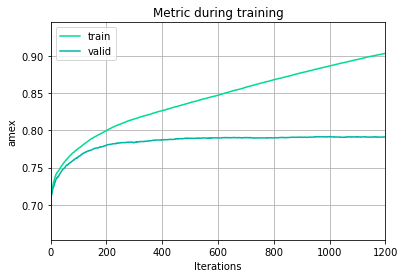

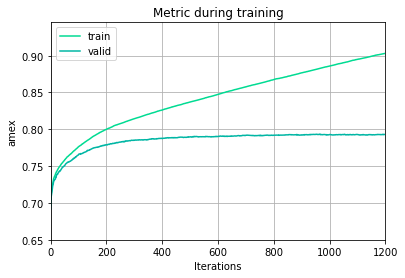

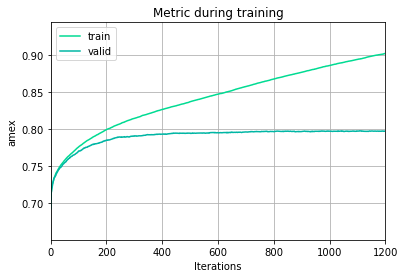

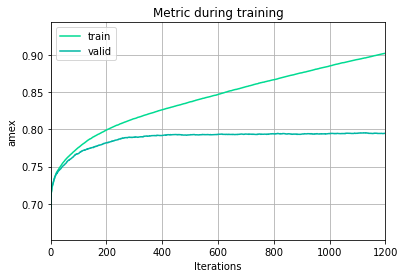

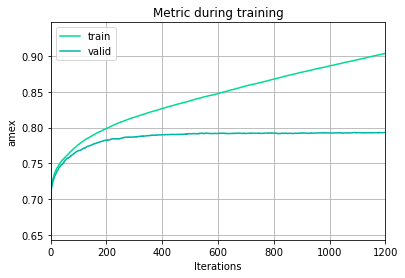

In [12]:
lgb_params = {"learning_rate": 0.03,
              'reg_lambda': 50,
              'min_child_samples': 2400,
              'num_leaves': 95,
              "metric" : "None",
              'max_bin': 511}

models = fit_lgbm(train[features], train[Config.target], params=lgb_params)
# models = [joblib.load(f'{EXP_MODEL}/lgbm_fold{i}.pkl') for i in range(Config.n_splits)]
pred = inference_lgbm(models, test[features])


## Plot importances

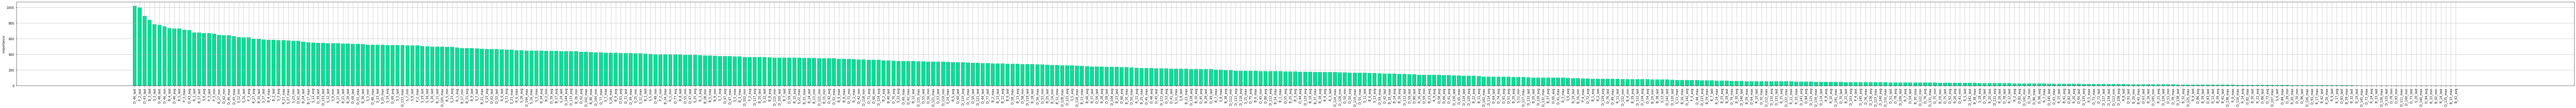

In [13]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

## Submission

In [14]:
sub = pd.DataFrame({'customer_ID': test.index,
                    'prediction': pred})
sub.to_csv(f'{SUBMISSION}/submission.csv', index=False)

In [16]:
! kaggle competitions submit -c amex-default-prediction -f /home/abe/kaggle/kaggle-amex/submissions/submission.csv -m "lightGBM Baseline"

100%|██████████████████████████████████████| 75.3M/75.3M [00:14<00:00, 5.53MB/s]
Successfully submitted to American Express - Default Prediction